In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# POTATO LEAF DISEASE CLASSIFICATION
- Based on three classes (Early Blight, Late Blight and Healthy)

## Import all the required modules and dependencies

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


## Set the constant values

In [1]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3


## Import the dataset

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "c:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem\ML_Project/MCA Sem 1 ML Project-20241125T080316Z-001/MCA Sem 1 ML Project/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

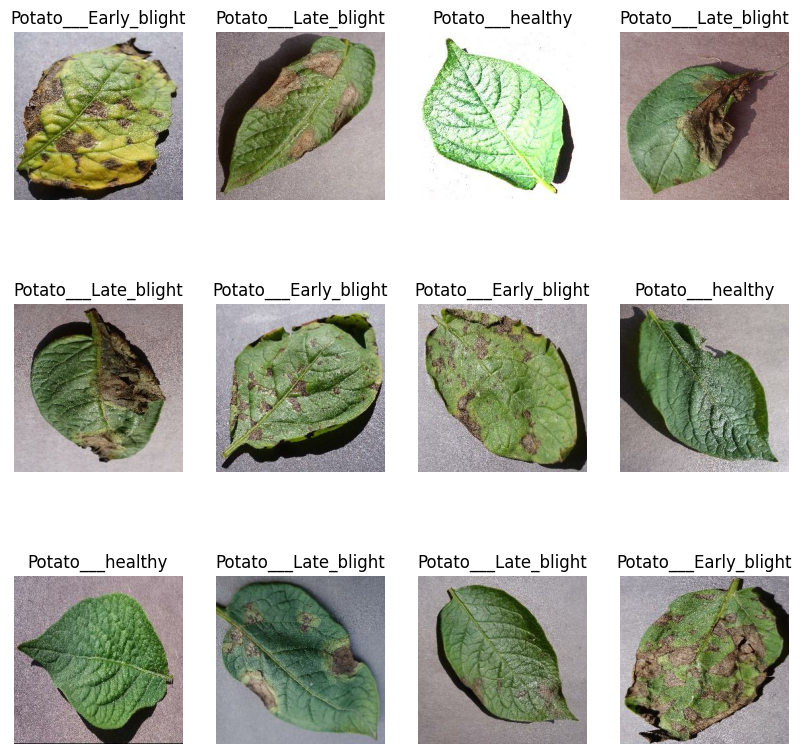

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Quantization**

In [10]:
import tensorflow as tf
from PIL import Image
import numpy as np

def quantize_image_region(image, num_levels=5):
    """Quantize an image region to specified levels."""
    image = tf.cast(image, tf.float32)
    image_min = tf.reduce_min(image)
    image_max = tf.reduce_max(image)

    # Normalize the image to [0, 1]
    image = (image - image_min) / (image_max - image_min)

    # Quantize to specified number of levels
    image = tf.floor(image * num_levels) / num_levels

    # Rescale back to the original range
    image = image * (image_max - image_min) + image_min
    return image

def quantize_image_into_parts(image_path, num_levels=5):
    """Quantize an image into parts based on the grid and apply quantization."""
    # Open the image and convert to numpy array
    img = Image.open(image_path)
    img_np = np.array(img)
    height, width, channels = img_np.shape

    # Define regions (part_coords)
    part_coords = {
        1: (0, 0, width // 2, height // 2),  # Top-left quadrant
        2: (width // 2, 0, width, height // 2),  # Top-right quadrant
        3: (width // 2, height // 2, width, height),  # Bottom-right quadrant
        4: (0, height // 2, width // 2, height),  # Bottom-left quadrant
        5: (
            width // 4, height // 4,  # Center smaller rectangle
            3 * width // 4, 3 * height // 4
        ),
    }

    quantized_parts = {}

    # Process each region
    for part, (x1, y1, x2, y2) in part_coords.items():
        region = img_np[y1:y2, x1:x2]
        quantized_region = quantize_image_region(region, num_levels)
        quantized_parts[part] = quantized_region.numpy()

    return quantized_parts


In [11]:
# prompt: apply above quantization on all image in the dataset

import os

# Assuming your dataset directory is in the same location as before.
dataset_dir = "/content/drive/MyDrive/MCA Sem 1 ML Project-20241125T080316Z-001/MCA Sem 1 ML Project/train"
quantized_dataset_dir = "/content/drive/MyDrive/quantized_dataset" # Create a new directory for the quantized images

# Create the directory if it doesn't exist.
os.makedirs(quantized_dataset_dir, exist_ok=True)


for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    quantized_class_dir = os.path.join(quantized_dataset_dir, class_name)
    os.makedirs(quantized_class_dir, exist_ok=True)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
          quantized_parts = quantize_image_into_parts(image_path)
          # Save each quantized part as a separate image (or combine them as needed)
          for part, quantized_image in quantized_parts.items():
              # Ensure the quantized image data type is uint8 before saving.
              quantized_image = quantized_image.astype(np.uint8)
              new_image_name = f"{image_name[:-4]}_part{part}{image_name[-4:]}"
              new_image_path = os.path.join(quantized_class_dir, new_image_name)
              Image.fromarray(quantized_image).save(new_image_path)
        except Exception as e:
          print(f"Error processing image {image_name}: {e}")

In [3]:
# prompt: load the quantized_dataset

import tensorflow as tf
# Assuming quantized_dataset_dir is defined as in the previous code.
quantized_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem/ML_Project/quantized_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = quantized_dataset.class_names
class_names

Found 28530 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

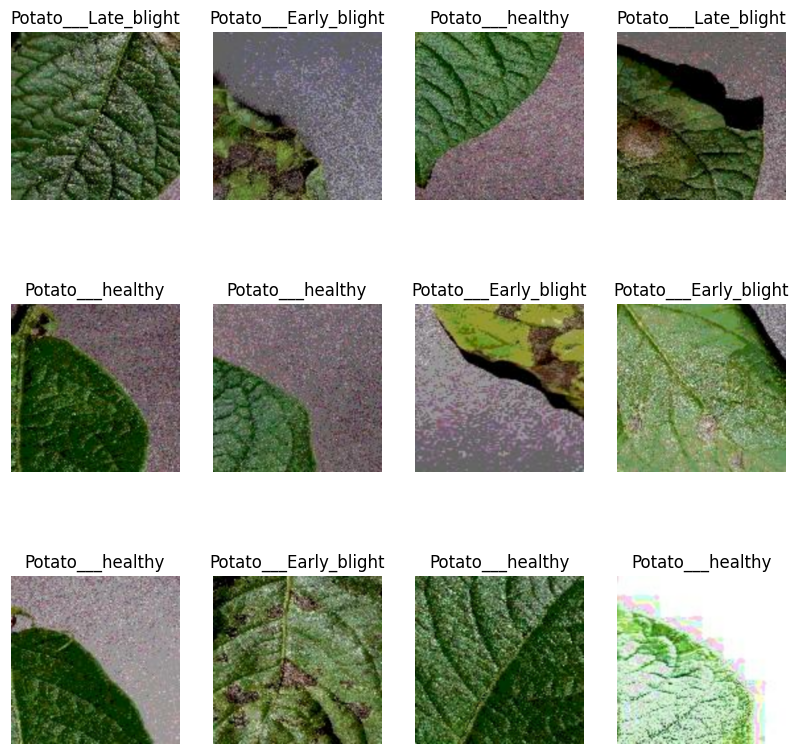

In [4]:
# prompt: visualize quantized_dataset

import matplotlib.pyplot as plt

# Assuming quantized_dataset is defined as in the previous code.
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in quantized_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()

## Spliting the Dataset (80-10-10)

In [5]:
# prompt: split quantized data

def split_dataset(dataset, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    # Calculate the sizes for validation and test sets
    dataset_size = len(dataset)
    val_size = int(dataset_size * val_size)
    test_size = int(dataset_size * test_size)

    # Split the dataset into training, validation, and test sets
    train_dataset = dataset.skip(val_size + test_size)
    val_dataset = dataset.take(val_size)
    test_dataset = dataset.skip(val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(quantized_dataset)

# Print the sizes of the datasets to verify
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 714
Validation dataset size: 89
Test dataset size: 89


## Cache, Shuffle, and Prefetch the Dataset

---



In [6]:
import tensorflow as tf

# ... other code ...


def split_dataset(dataset, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    # Calculate the sizes for validation and test sets
    dataset_size = len(dataset)
    val_size = int(dataset_size * val_size)
    test_size = int(dataset_size * test_size)

    # Split the dataset into training, validation, and test sets
    train_dataset = dataset.skip(val_size + test_size)
    val_dataset = dataset.take(val_size)
    test_dataset = dataset.skip(val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

# Call the function to create the datasets
train_dataset, val_dataset, test_dataset = split_dataset(quantized_dataset)

# ... Now you can use train_dataset, val_dataset, and test_dataset ...

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Building the Model
(Resize, Rescale and Augmentation)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers # Import the layers module

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

# CNN MODEL ARCHITECTURE

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Fifth Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Sixth Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening and Fully Connected Layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with 3 classes
])


C:\Users\Rohan Dutta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
class Encoders:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        """
        Initializes the optimizer.
        :param params: List of parameters to optimize.
        :param lr: Learning rate.
        :param beta1: Decay rate for the first moment (momentum).
        :param beta2: Decay rate for the second moment (adaptive learning rate).
        :param epsilon: Small constant to prevent division by zero.
        """
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p) for p in params]  # Initialize first moments
        self.v = [np.zeros_like(p) for p in params]  # Initialize second moments
        self.t = 0  # Time step

    def step(self, gradients):
        """
        Performs an optimization step.
        :param gradients: List of gradients corresponding to the parameters.
        """
        self.t += 1
        updated_params = []
        
        for i, (p, g) in enumerate(zip(self.params, gradients)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            
            # Update biased second moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            
            # Correct bias in moment estimates
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            p_update = p - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            updated_params.append(p_update)
        
        self.params = updated_params

    def zero_grad(self):
        """Resets gradients (not strictly necessary here but often used in frameworks)."""
        self.m = [np.zeros_like(m) for m in self.m]
        self.v = [np.zeros_like(v) for v in self.v]


In [9]:
model_path = 'C:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem/ML_Project/first_potatoleaf_model.h5'

model = tf.keras.models.load_model(model_path)

In [10]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,749 (717.77 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Compiling the Model
### (Using adam as the optimizer)

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_dataset,  # Changed train_ds to train_dataset
    batch_size=BATCH_SIZE,
    validation_data=val_dataset, # Changed val_ds to val_dataset
    verbose=1,
    epochs=5,
)

Epoch 1/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 1044s 1s/step - accuracy: 0.8624 - loss: 0.4230 - val_accuracy: 0.9182 - val_loss: 0.2175
Epoch 2/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - accuracy: 0.9333 - loss: 0.1802 - val_accuracy: 0.9059 - val_loss: 0.2546
Epoch 3/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.9484 - loss: 0.1361 - val_accuracy: 0.9568 - val_loss: 0.1100
Epoch 4/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.9570 - loss: 0.1175 - val_accuracy: 0.9438 - val_loss: 0.1489
Epoch 5/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.9593 - loss: 0.1122 - val_accuracy: 0.9670 - val_loss: 0.0904


In [13]:
scores = model.evaluate(train_dataset)
scores

714/714 ━━━━━━━━━━━━━━━━━━━━ 327s 458ms/step - accuracy: 0.9778 - loss: 0.0636


[0.0636402890086174, 0.978759765625]

In [15]:
accuracy = scores[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.88%


### A 99.18% accuracy is achieved using CNN Model

# Plotting the Accuracy and Loss Curves

In [16]:
history

In [17]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 714}

In [18]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [19]:
history.history['accuracy'][:5]

[0.9045721292495728,
 0.9405710697174072,
 0.9480599164962769,
 0.9555049538612366,
 0.9601033329963684]

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

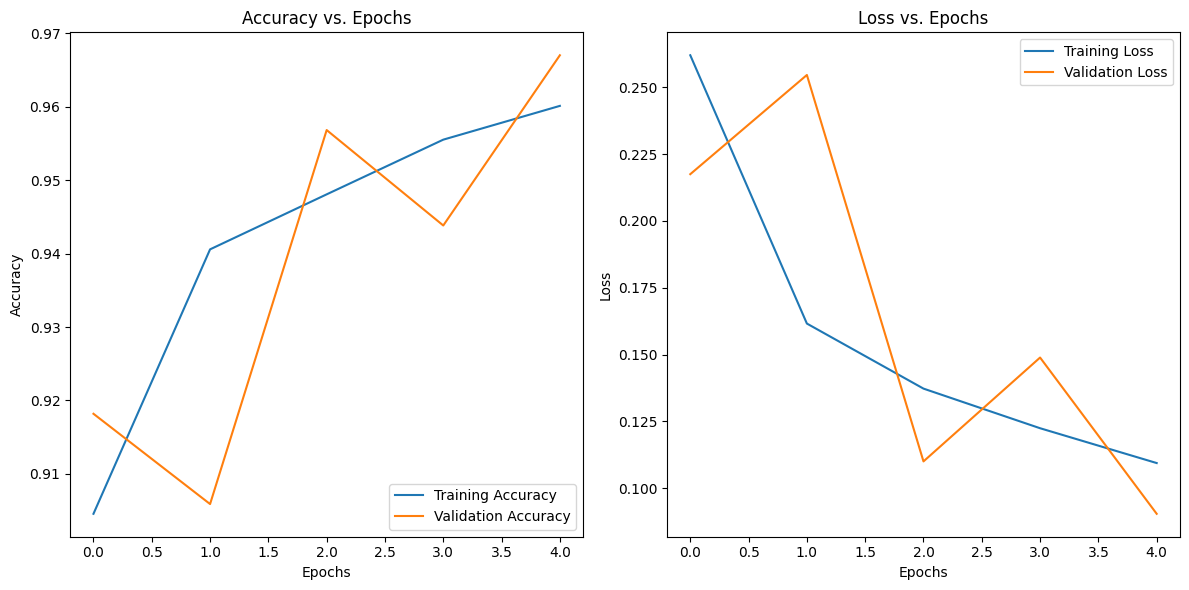

In [21]:
epochs_range = range(len(acc))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## SAVING THE MODEL

In [20]:
model.save('potatoCNN_kerasmodel.keras')

## LOADING THE SAVED MODEL (FOR CHECKING)

In [21]:
from tensorflow.keras.models import load_model

loaded_model = load_model('potatoCNN_kerasmodel.keras')

## TESTING A SAMPLE IMAGE FROM TEST SPLIT

First image to predict:


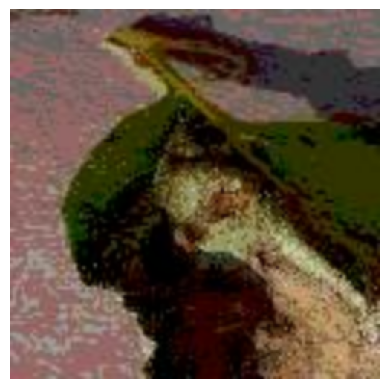

Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
Predicted label: Potato___Late_blight


In [22]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])  # Get the predicted class for the first image
    print("Predicted label:", class_names[predicted_label])

# RUNNING AN INFERENCE OF FEW SAMPLE IMAGES

In [23]:
def predict(model, img):
    img_array = tf.expand_dims(img, axis=0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


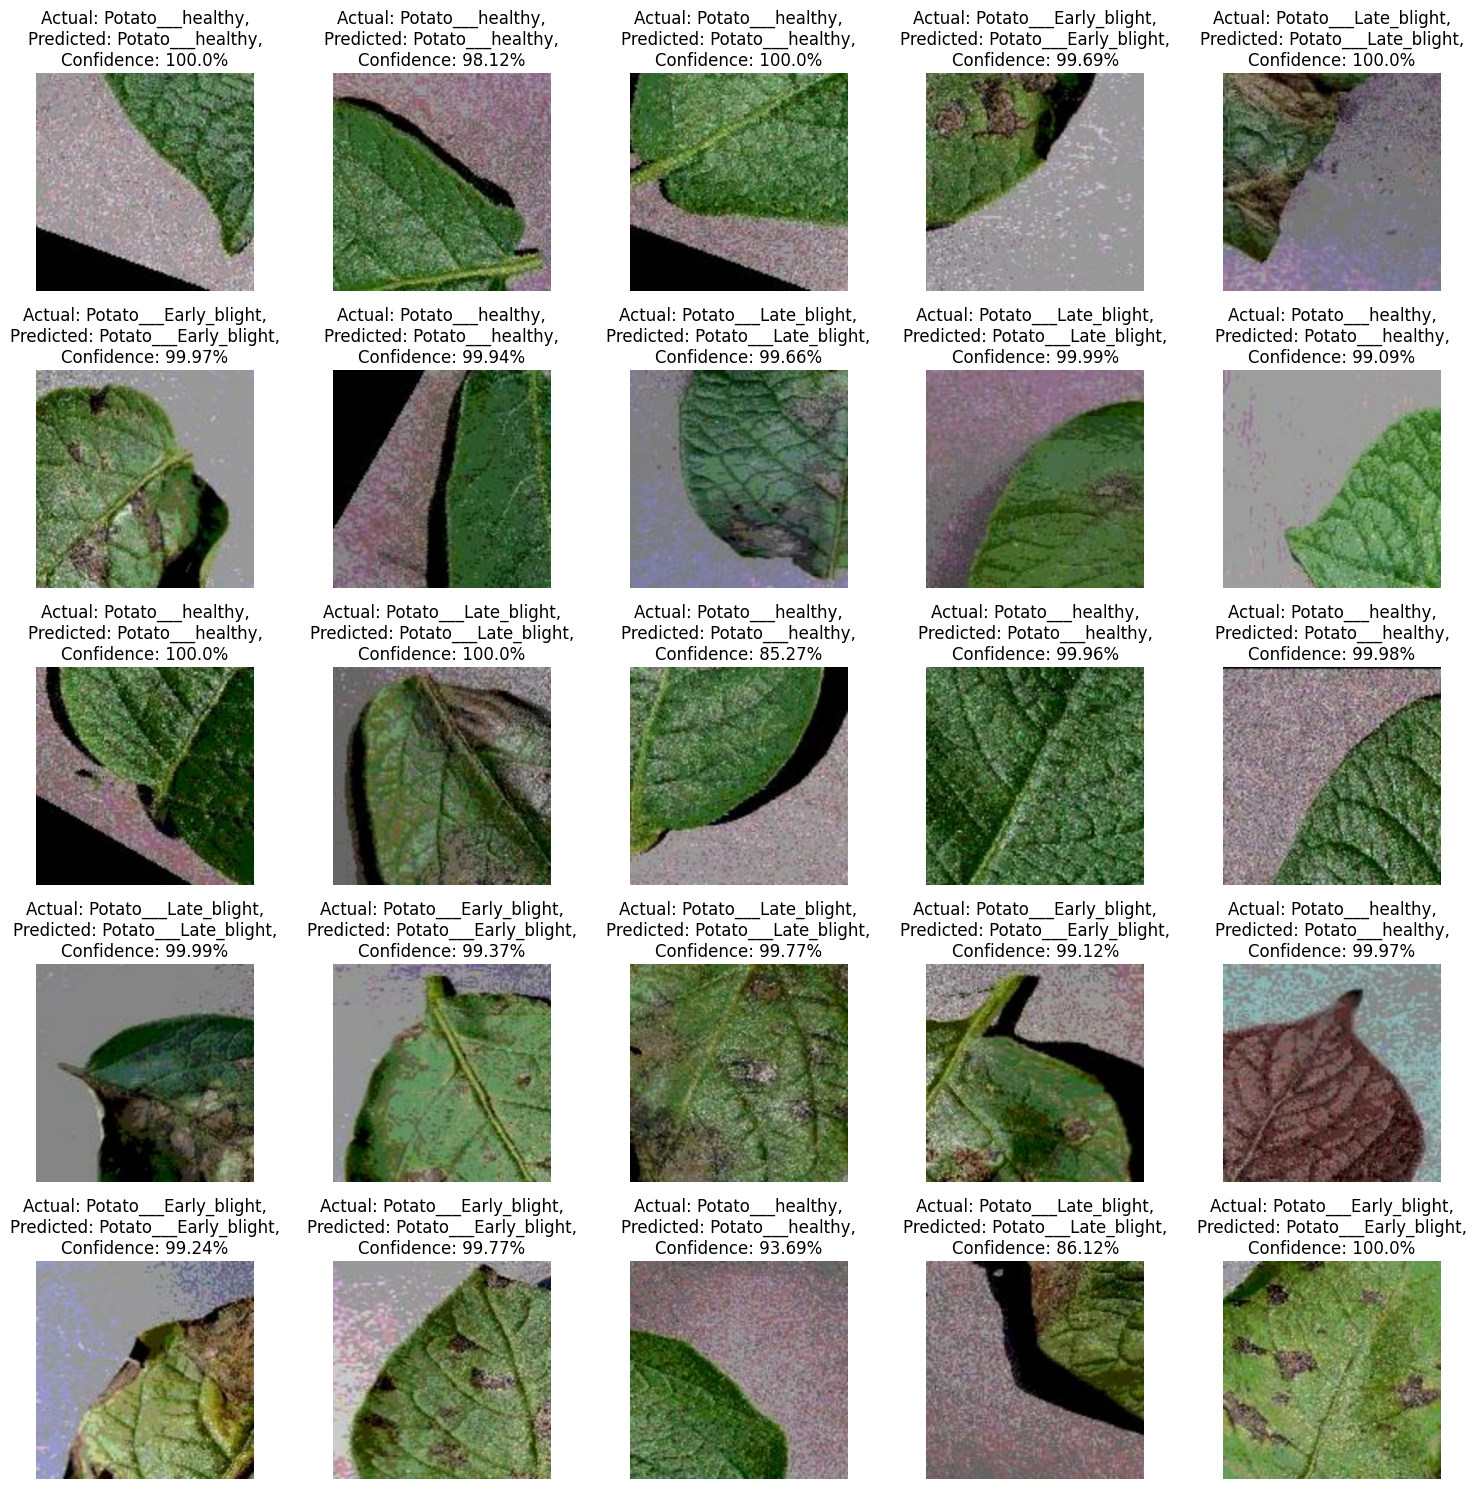

In [24]:
num_images = 25
rows = int(num_images**0.5)
cols = int(np.ceil(num_images / rows))

plt.figure(figsize=(15, 15))
image_count = 0

for images, labels in test_dataset:
    for i in range(len(images)):
        if image_count >= num_images:
            break
        ax = plt.subplot(rows, cols, image_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
        image_count += 1
    if image_count >= num_images:
        break

plt.tight_layout()
plt.show()

## PLOTTING THE CONFUSION MATRIX
- Diagonal values show correct predictions.
- Off-diagonal values show misclassifications.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

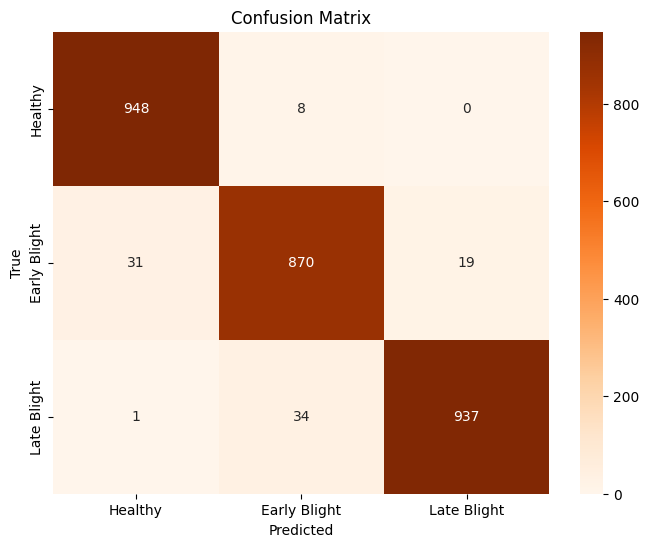

[[948   8   0]
 [ 31 870  19]
 [  1  34 937]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       956
           1       0.95      0.95      0.95       920
           2       0.98      0.96      0.97       972

    accuracy                           0.97      2848
   macro avg       0.97      0.97      0.97      2848
weighted avg       0.97      0.97      0.97      2848



In [25]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score, classification_report, confusion_matrix

class_names = ['Healthy', 'Early Blight', 'Late Blight']

true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    batch_predictions = model.predict(images)
    predicted_labels_batch = np.argmax(batch_predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(classification_report(true_labels, predicted_labels))